Import neccessary packages

In [3]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
EPOCHS = 30
INIT_LR = 6e-4
BS = 32
width=64
height=64
default_image_size = tuple((width, height))
image_size = 0
directory_root = 'input/plantvillage/'
depth=3

Function to convert images to array

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [6]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    print(directory_root)
    root_dir = listdir(directory_root)
    for directory in root_dir :
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        for disease_folder in plant_disease_folder_list :
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)
            if disease_folder == ".ipynb_checkpoints" :
                plant_disease_folder_list.remove(disease_folder)
            if "Untitled" in disease_folder :
                plant_disease_folder_list.remove(disease_folder)
                
        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:500]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
input/plantvillage/
[INFO] Processing Potato__healthy ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Bacterial_spot ...
[INFO] Processing Pepper_bell__healthy ...
[INFO] Processing Pepper_bell__Bacterial_spot ...
[INFO] Processing Potato__Early_blight ...
[INFO] Processing Potato__Late_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato__Healthy ...
[INFO] Image loading completed


Get Size of Processed Image

In [7]:
image_size = len(image_list)

In [8]:
image_size

4522

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [9]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [10]:
image_labels.sum(axis = 0)

array([499, 499, 500, 500, 152, 500, 500, 500, 499, 373])

In [11]:
label_binarizer.classes_

array(['Pepper_bell__Bacterial_spot', 'Pepper_bell__healthy',
       'Potato__Early_blight', 'Potato__Late_blight', 'Potato__healthy',
       'Tomato__Bacterial_spot', 'Tomato__Healthy', 'Tomato__Target_Spot',
       'Tomato__Tomato_YellowLeaf__Curl_Virus',
       'Tomato__Tomato_mosaic_virus'], dtype='<U37')

In [12]:
pcc = dict(zip(label_binarizer.classes_, image_labels.sum(axis = 0)))
pcc

{'Pepper_bell__Bacterial_spot': 499,
 'Pepper_bell__healthy': 499,
 'Potato__Early_blight': 500,
 'Potato__Late_blight': 500,
 'Potato__healthy': 152,
 'Tomato__Bacterial_spot': 500,
 'Tomato__Healthy': 500,
 'Tomato__Target_Spot': 500,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 499,
 'Tomato__Tomato_mosaic_virus': 373}

<BarContainer object of 10 artists>

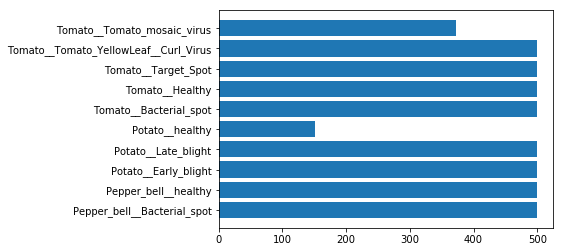

In [29]:
plt.barh(list(pcc.keys()), list(pcc.values()))

In [30]:
np.sum([(x/8519)**2 for x in image_labels.sum(axis = 0)])

0.029752459721412102

Print the classes

In [31]:
np_image_list = np.array(image_list) / 255.0

In [32]:
def do_a_run(rstate = 200):
    x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.25, random_state = 100)
    aug = ImageDataGenerator(
        rotation_range=30, height_shift_range=0.15, shear_range=0.15, 
        zoom_range=0.2,horizontal_flip=True, 
        fill_mode="nearest")
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(64, (2, 2), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))

    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer= opt, metrics=["accuracy"])
    from tensorflow.keras.callbacks import ModelCheckpoint
    filepath="BEST-128x128-rstate-"+str(rstate) + "-weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    history = model.fit_generator(
        aug.flow(x_train, y_train, batch_size=BS),
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train) // BS,
        epochs=EPOCHS, verbose=1, callbacks=callbacks_list)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

    return acc, val_acc, loss, val_loss, epochs

Model Summary

Epoch 1/30
104/105 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9255
Epoch 00001: val_accuracy improved from -inf to 0.82334, saving model to BEST-128x128-rstate-100-weights-improvement-01-0.82.hdf5
105/105 [==============================] - 8s 80ms/step - loss: 0.2133 - accuracy: 0.9259 - val_loss: 1.1733 - val_accuracy: 0.8233
Epoch 2/30
104/105 [============================>.] - ETA: 0s - loss: 0.1181 - accuracy: 0.9562
Epoch 00002: val_accuracy improved from 0.82334 to 0.82812, saving model to BEST-128x128-rstate-100-weights-improvement-02-0.83.hdf5
105/105 [==============================] - 8s 79ms/step - loss: 0.1180 - accuracy: 0.9561 - val_loss: 0.8086 - val_accuracy: 0.8281
Epoch 3/30
104/105 [============================>.] - ETA: 0s - loss: 0.0929 - accuracy: 0.9655
Epoch 00003: val_accuracy did not improve from 0.82812
105/105 [==============================] - 8s 75ms/step - loss: 0.0927 - accuracy: 0.9655 - val_loss: 1.1981 - val_accuracy: 0.823

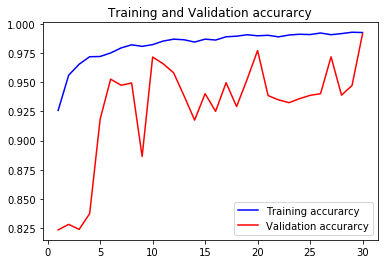

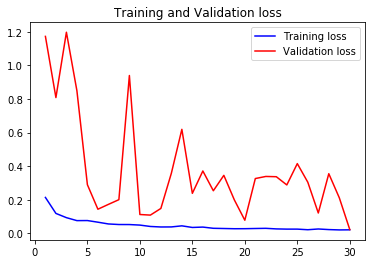

In [33]:
acc1, val_acc1, loss1, val_loss1, epochs1 = do_a_run(rstate=100)

Epoch 1/30
104/105 [============================>.] - ETA: 0s - loss: 0.2005 - accuracy: 0.9292
Epoch 00001: val_accuracy improved from -inf to 0.82334, saving model to BEST-128x128-rstate-200-weights-improvement-01-0.82.hdf5
105/105 [==============================] - 8s 79ms/step - loss: 0.2001 - accuracy: 0.9295 - val_loss: 0.8780 - val_accuracy: 0.8233
Epoch 2/30
104/105 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9572
Epoch 00002: val_accuracy improved from 0.82334 to 0.82573, saving model to BEST-128x128-rstate-200-weights-improvement-02-0.83.hdf5
105/105 [==============================] - 8s 80ms/step - loss: 0.1149 - accuracy: 0.9574 - val_loss: 0.8859 - val_accuracy: 0.8257
Epoch 3/30
104/105 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9662
Epoch 00003: val_accuracy improved from 0.82573 to 0.83254, saving model to BEST-128x128-rstate-200-weights-improvement-03-0.83.hdf5
105/105 [==============================] - 8s 77ms/s

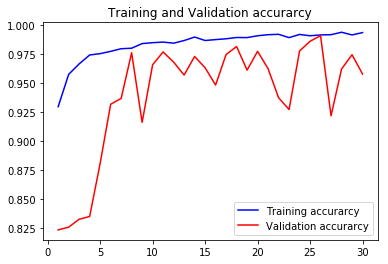

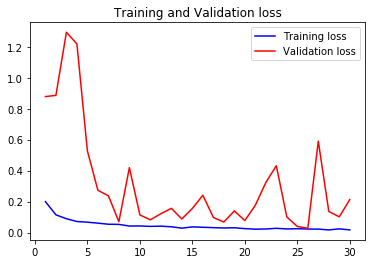

In [34]:
acc2, val_acc2, loss2, val_loss2, epochs2 = do_a_run(rstate=200)

Epoch 1/30
104/105 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9270
Epoch 00001: val_accuracy improved from -inf to 0.82334, saving model to BEST-128x128-rstate-300-weights-improvement-01-0.82.hdf5
105/105 [==============================] - 8s 74ms/step - loss: 0.2114 - accuracy: 0.9269 - val_loss: 1.2200 - val_accuracy: 0.8233
Epoch 2/30
104/105 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9524
Epoch 00002: val_accuracy did not improve from 0.82334
105/105 [==============================] - 8s 75ms/step - loss: 0.1247 - accuracy: 0.9525 - val_loss: 1.6945 - val_accuracy: 0.8233
Epoch 3/30
104/105 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.9638
Epoch 00003: val_accuracy improved from 0.82334 to 0.84350, saving model to BEST-128x128-rstate-300-weights-improvement-03-0.84.hdf5
105/105 [==============================] - 8s 79ms/step - loss: 0.1014 - accuracy: 0.9637 - val_loss: 1.1477 - val_accuracy: 0.843

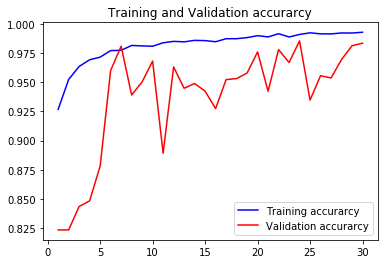

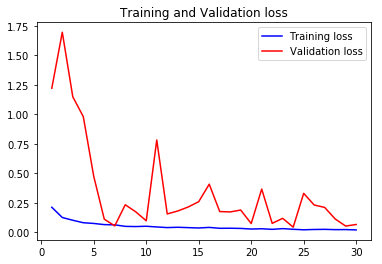

In [35]:
acc3, val_acc3, loss3, val_loss3, epochs3 = do_a_run(rstate=300)

Epoch 1/30
104/105 [============================>.] - ETA: 0s - loss: 0.2114 - accuracy: 0.9258
Epoch 00001: val_accuracy improved from -inf to 0.82334, saving model to BEST-128x128-rstate-400-weights-improvement-01-0.82.hdf5
105/105 [==============================] - 8s 74ms/step - loss: 0.2101 - accuracy: 0.9261 - val_loss: 0.6738 - val_accuracy: 0.8233
Epoch 2/30
104/105 [============================>.] - ETA: 0s - loss: 0.1207 - accuracy: 0.9552
Epoch 00002: val_accuracy did not improve from 0.82334
105/105 [==============================] - 8s 74ms/step - loss: 0.1209 - accuracy: 0.9552 - val_loss: 1.2864 - val_accuracy: 0.8233
Epoch 3/30
104/105 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.9625
Epoch 00003: val_accuracy improved from 0.82334 to 0.83581, saving model to BEST-128x128-rstate-400-weights-improvement-03-0.84.hdf5
105/105 [==============================] - 8s 77ms/step - loss: 0.1010 - accuracy: 0.9625 - val_loss: 0.9347 - val_accuracy: 0.835

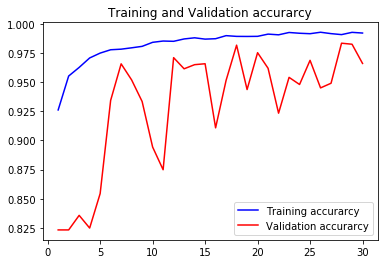

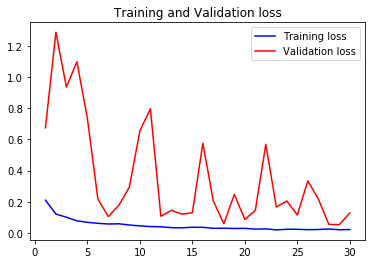

In [36]:
acc4, val_acc4, loss4, val_loss4, epochs4 = do_a_run(rstate=400)

Epoch 1/30
104/105 [============================>.] - ETA: 0s - loss: 0.2071 - accuracy: 0.9265
Epoch 00001: val_accuracy improved from -inf to 0.82334, saving model to BEST-128x128-rstate-500-weights-improvement-01-0.82.hdf5
105/105 [==============================] - 8s 78ms/step - loss: 0.2066 - accuracy: 0.9266 - val_loss: 0.8865 - val_accuracy: 0.8233
Epoch 2/30
104/105 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9564
Epoch 00002: val_accuracy did not improve from 0.82334
105/105 [==============================] - 8s 74ms/step - loss: 0.1178 - accuracy: 0.9566 - val_loss: 1.5336 - val_accuracy: 0.8233
Epoch 3/30
104/105 [============================>.] - ETA: 0s - loss: 0.1007 - accuracy: 0.9619
Epoch 00003: val_accuracy improved from 0.82334 to 0.83351, saving model to BEST-128x128-rstate-500-weights-improvement-03-0.83.hdf5
105/105 [==============================] - 8s 77ms/step - loss: 0.1005 - accuracy: 0.9620 - val_loss: 1.1236 - val_accuracy: 0.833

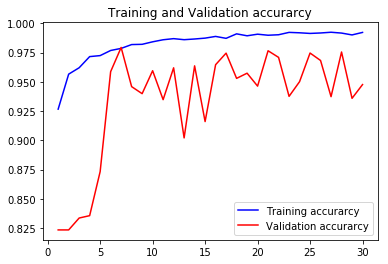

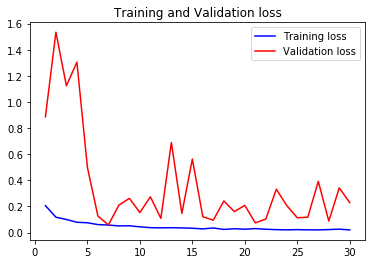

In [37]:
acc5, val_acc5, loss5, val_loss5, epochs5 = do_a_run(rstate=500)

In [38]:
val_accs = np.vstack([val_acc1,val_acc2,val_acc3,val_acc4,val_acc5])

In [39]:
np.max(np.sum(val_accs, axis = 0)/5)

0.9704156

In [18]:
model_json = model.to_json()
with open("500samples_gulai_best_64x64_98.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("500samples_gulai_best_64x64.hdf5")
print("Saved model to disk")

Saved model to disk


In [16]:
from sklearn.metrics import confusion_matrix
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test);
print(f"Test Accuracy: {scores[1]*100}")
y_pred = np.rint(model.predict(x_test))
confmat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

[INFO] Calculating model accuracy
1006/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [118]:
y_test.shape

(805, 9)

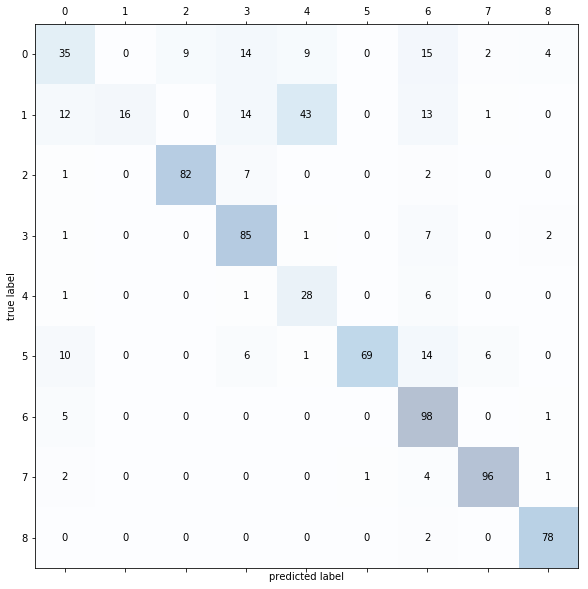

In [113]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

In [120]:
label_binarizer.classes_

array(['Pepper_bell__Bacterial_spot', 'Pepper_bell__healthy',
       'Potato__Early_blight', 'Potato__Late_blight', 'Potato__healthy',
       'Tomato__Bacterial_spot', 'Tomato__Target_Spot',
       'Tomato__Tomato_YellowLeaf__Curl_Virus',
       'Tomato__Tomato_mosaic_virus'], dtype='<U37')

In [114]:
len(label_list)

4022

In [25]:
x_test.dtype

dtype('float16')

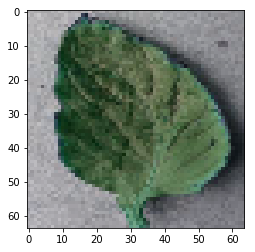

In [26]:
plt.imshow(x_test[10].astype('float32'))

In [27]:
y_test[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 0])

In [40]:
def convert_image_to_array_spec(image_dir, size = 256):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (size,size))   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

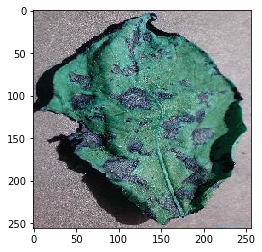

In [41]:
plt.imshow(convert_image_to_array_spec('input/plantvillage/plants/Potato__Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG')/255)

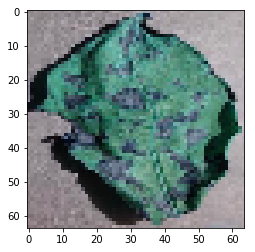

In [42]:
plt.imshow(convert_image_to_array_spec('input/plantvillage/plants/Potato__Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG', size = 64)/255)

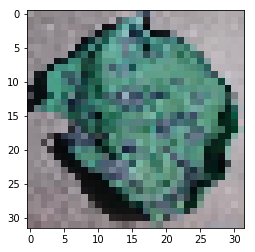

In [43]:
plt.imshow(convert_image_to_array_spec('input/plantvillage/plants/Potato__Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG', size = 32)/255)

In [45]:
label_binarizer.classes_

array(['Pepper_bell__Bacterial_spot', 'Pepper_bell__healthy',
       'Potato__Early_blight', 'Potato__Late_blight', 'Potato__healthy',
       'Tomato__Bacterial_spot', 'Tomato__Target_Spot',
       'Tomato__Tomato_YellowLeaf__Curl_Virus',
       'Tomato__Tomato_mosaic_virus'], dtype='<U37')